In [1]:
from datetime import date, timedelta
from constants import *
from bars import plot_bars as plot_areas, unique_people_tested
from phe import *
from phe import map_data as phe_map_data
from zoe import latest_map_data as zoe_map_data
from plotting import *
from vaccination import vaccination_dashboard, vaccination_changes
for_date = '*'

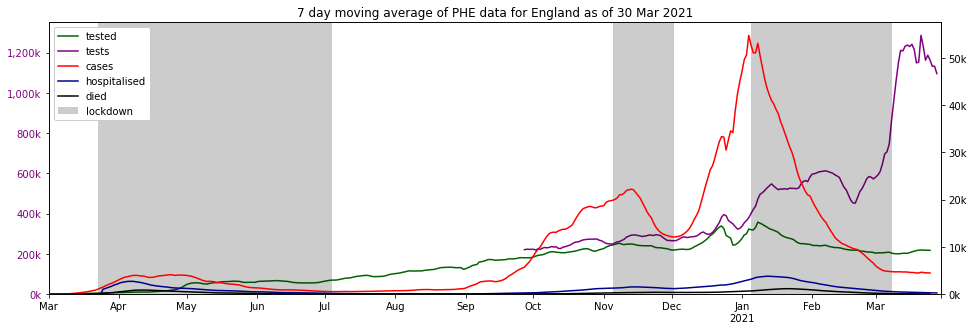

In [2]:
plot_summary(left_series=(s.unique_people_tested_sum, s.new_virus_tests_sum),
             right_series=(s.new_cases_sum, s.new_admissions_sum, s.new_deaths_sum))

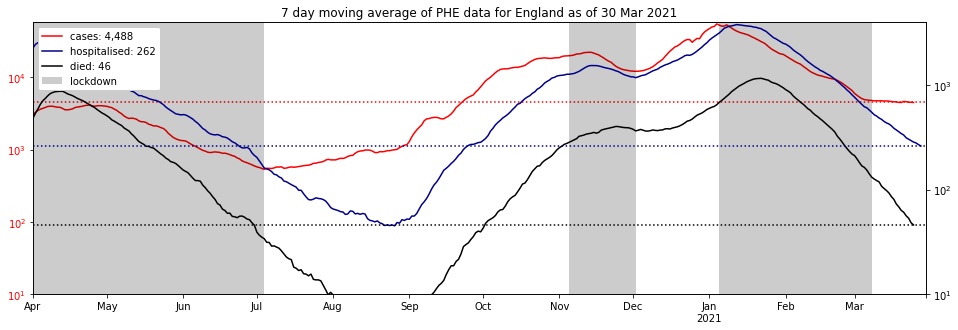

In [3]:
plot_summary(earliest_date='2020-04-01', show_latest='lines', log=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0k_formatter)

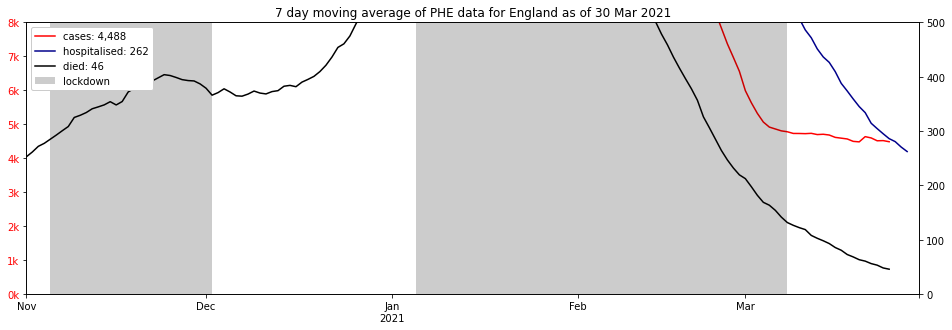

In [4]:
plot_summary(earliest_date='2020-11-01', show_latest=True,
             left_series=(s.new_cases_sum,), left_formatter=per1k_formatter, left_ymax=8_000,
             right_series=(s.new_admissions_sum, s.new_deaths_sum), right_formatter=per0_formatter, right_ymax=500)

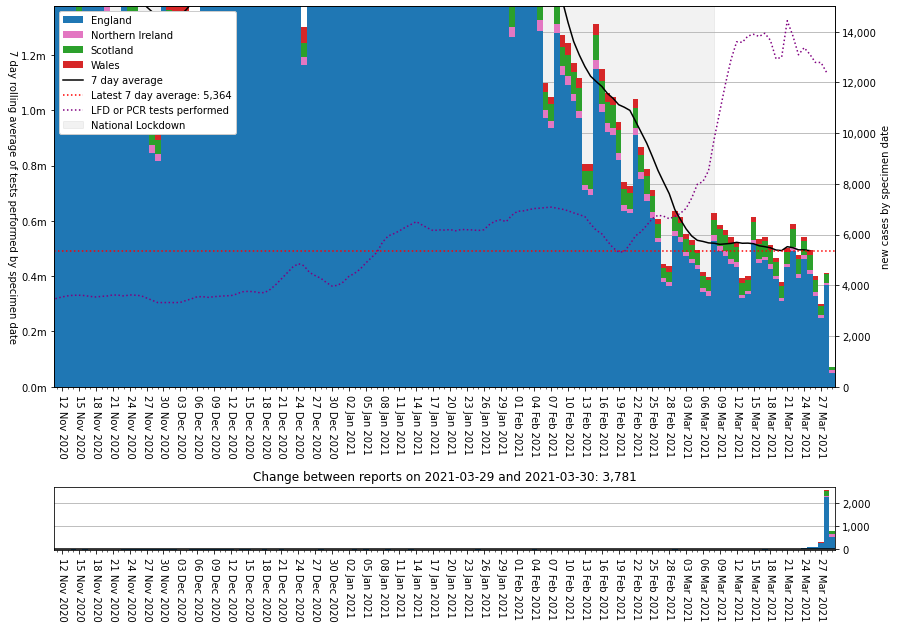

In [5]:
plot_areas(for_date, 'cases_nations', ylim=15_000, earliest='2020-11-11')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,England,E92000001,2943529.0,26090111.0,23146582.0,56286961,5.229504,41.122458,53.648038
1,Northern Ireland,N92000002,132022.0,740729.0,608707.0,1893667,6.971764,32.144353,60.883883
2,Scotland,S92000003,338443.0,2436398.0,2097955.0,5463300,6.194846,38.400875,55.404279
3,Wales,W92000004,424016.0,1413710.0,989694.0,3152879,13.448534,31.390168,55.161299


'partial: 30,680,948 (45.9%), full: 3,838,010'

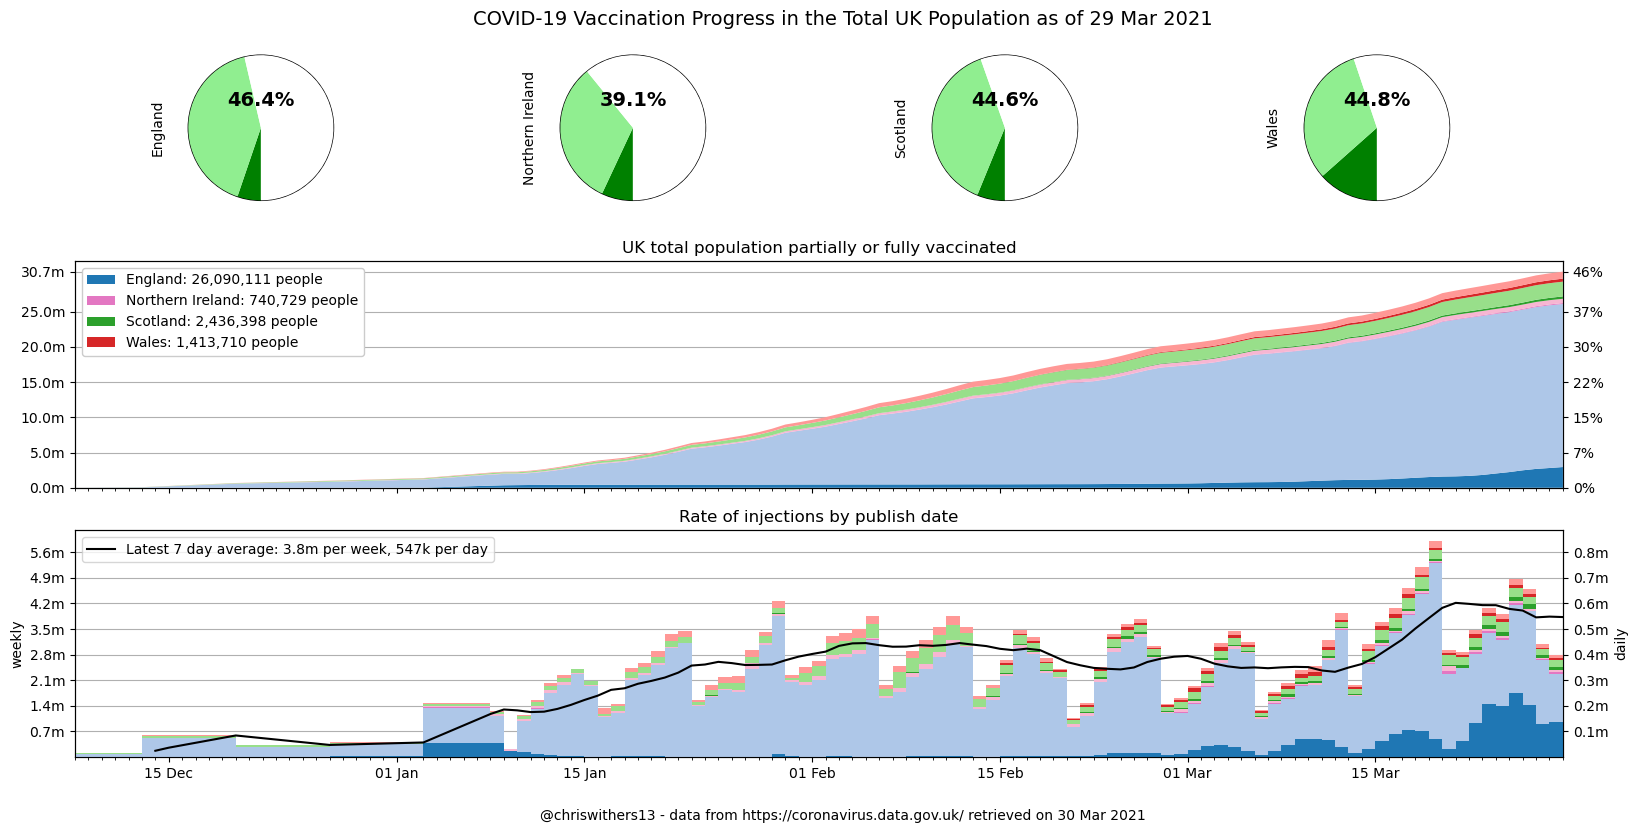

In [6]:
results = vaccination_dashboard(show_partial=True)
partial = results['any'].sum()
population = results['population'].sum()
display(results, f"partial: {partial:,.0f} ({partial/population:.1%}), full: {results['full'].sum():,.0f}")

In [7]:
vaccination_changes()

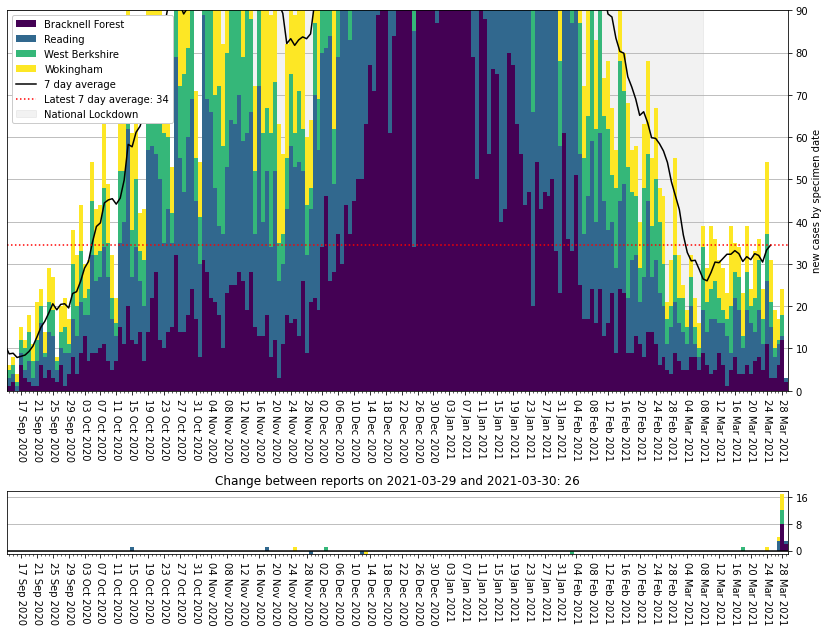

In [8]:
plot_areas(for_date, areas=my_areas, earliest='2020-09-14', ylim=90)

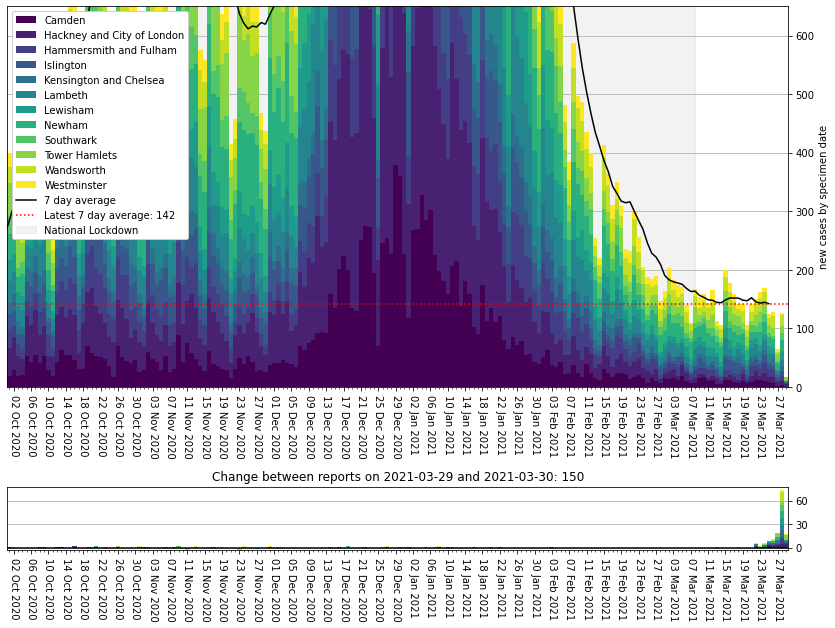

In [9]:
plot_areas(for_date, areas=london_areas, ylim=650)

In [10]:
data = recent_phe_data_summed(for_date)
top_10_cols = [area_name,per100k,new_cases_by_specimen_date, specimen_date]

In [11]:
top_10 = data.sort_values(per100k, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E07000150,Corby,193.857487,140.0,2021-03-29
S12000005,Clackmannanshire,157.159488,81.0,2021-03-29
E08000018,Rotherham,140.159978,372.0,2021-03-29
E07000218,North Warwickshire,127.175778,83.0,2021-03-29
S12000040,West Lothian,122.883670,225.0,2021-03-29
N09000009,Mid Ulster,121.862544,181.0,2021-03-29
E08000016,Barnsley,120.713261,298.0,2021-03-29
E08000017,Doncaster,118.631569,370.0,2021-03-29
S12000050,North Lanarkshire,116.296101,397.0,2021-03-29


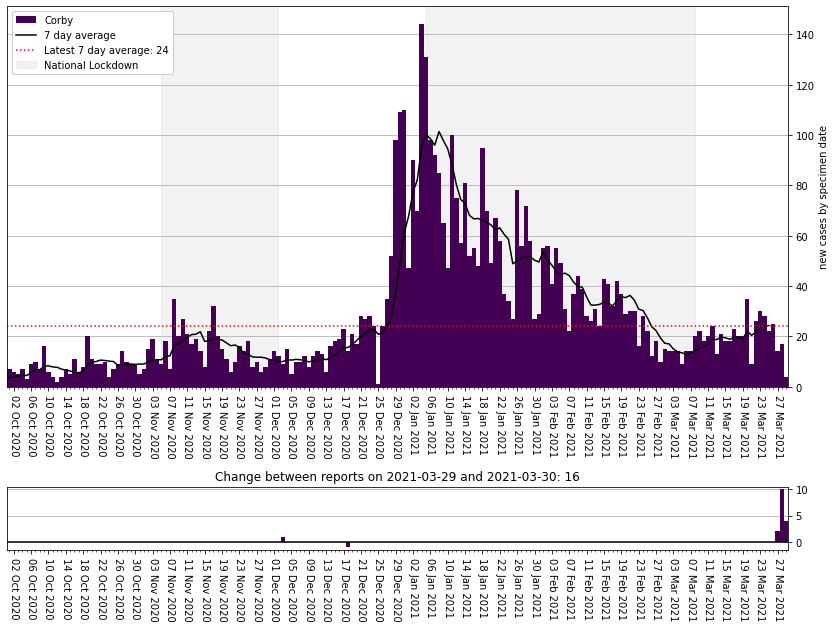

In [12]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [13]:
top_10 = data.sort_values(new_cases_by_specimen_date, ascending=False)[:10][top_10_cols]
top_10

,areaName,"per 100,000 people",newCasesBySpecimenDate,Specimen date
areaCode,,,,
E08000035,Leeds,98.469499,781.0,2021-03-29
E08000025,Birmingham,57.539919,657.0,2021-03-29
E08000019,Sheffield,103.957747,608.0,2021-03-29
E08000032,Bradford,108.934076,588.0,2021-03-29
S12000049,Glasgow City,72.656053,460.0,2021-03-29
E08000003,Manchester,78.320292,433.0,2021-03-29
E08000036,Wakefield,114.552470,399.0,2021-03-29
S12000050,North Lanarkshire,116.296101,397.0,2021-03-29
E08000018,Rotherham,140.159978,372.0,2021-03-29


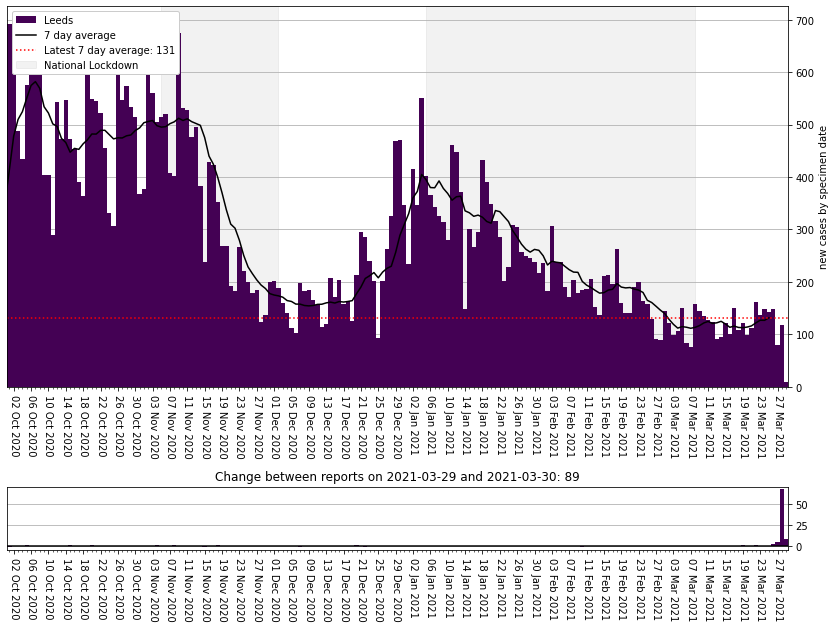

In [14]:
plot_areas(for_date, areas=[top_10.iloc[0].name])

In [15]:
zoe_date, zoe_df = zoe_map_data()
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)
zoe_max = 1.0
phe_max = 0.25

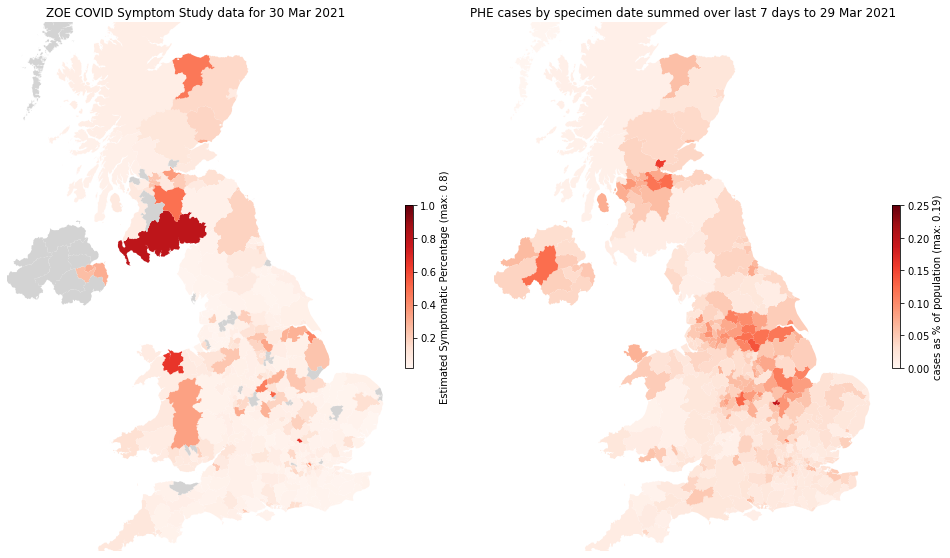

In [16]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

In [17]:
bokeh_zoe_vs_phe_map(zoe_df, zoe_date, zoe_max, phe_recent_geo, phe_recent_title, phe_max)

Loading BokehJS ...